In [ ]:
# CSC 180 Assignment 4 
# Due Date: 4/22/22
# Name: Stetten Fessler ID: 302267979
# Name: Nader S Opeyany ID: 301785393

import tensorflow as tf
import pandas as pd 
import numpy as np 
import nltk
from sklearn import metrics, preprocessing
import matplotlib.pyplot as plt
from collections.abc import Sequence
from google.colab import files
from nltk.sentiment import SentimentIntensityAnalyzer # Used to grade positive or negative sentiment
from wordcloud import WordCloud, STOPWORDS
import sklearn.feature_extraction.text as sk_text
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix


# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    print(f"Target type: {target_type}")
    classification = True
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if classification:
        # Classification
        print("Classifying correctly!")
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        print("incorrectly using regression")
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)
        
# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)

# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

def plot_sentiment(df, feature, title):
    counts = df[feature].value_counts()
    percent = counts/sum(counts)

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

    counts.plot(kind='bar', ax=ax1, color='green')
    percent.plot(kind='bar', ax=ax2, color='blue')
    ax1.set_ylabel(f'Counts : {title} sentiments', size=12)
    ax2.set_ylabel(f'Percentage : {title} sentiments', size=12)
    plt.suptitle(f"Sentiment analysis: {title}")
    plt.tight_layout()
    plt.show()

  # label encoder
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
print(tf.test.gpu_device_name()) # test if GPU enabled
nltk.download('vader_lexicon')

/device:GPU:0
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
uploaded = files.upload() # allows files to be uploaded from local disk

Saving reddit_politics.csv to reddit_politics.csv


In [ ]:
df = pd.read_csv("reddit_politics.csv",encoding="utf-8")
df

,title,score,id,url,comms_num,created,body,timestamp
0,A Right Wing Group in Texas Is Making up Fake ...,166,ov1ll3,https://www.vice.com/en/article/wx5bg5/blm-whi...,34,1.627710e+09,NaN,2021-07-31 08:35:47
1,DOJ sues Texas over Gov. Abbott’s order for la...,85,ouwc9i,https://www.kxan.com/news/texas-politics/doj-s...,17,1.627688e+09,NaN,2021-07-31 02:26:12
2,"From white evangelicals to QAnon believers, wh...",57,ouqkxi,https://www.modbee.com/news/coronavirus/articl...,27,1.627671e+09,NaN,2021-07-30 21:45:09
3,DeSantis says he’ll sign order allowing parent...,269,oun2lc,https://www.orlandosentinel.com/politics/os-ne...,138,1.627660e+09,NaN,2021-07-30 18:43:05
4,"Show on the road: In Utah, Florida Gov. Ron De...",31,ouipnz,https://www.tallahassee.com/story/news/politic...,28,1.627644e+09,NaN,2021-07-30 14:21:54
...,...,...,...,...,...,...,...,...
11340,Comment,1,h78eyen,NaN,0,1.627759e+09,A little lite fascism to start your day.,2021-07-31 19:22:26
11341,Comment,1,h78eycl,NaN,0,1.627759e+09,"Yeah sure, nobody’s believing this bullshit",2021-07-31 19:22:25
11342,Comment,1,h78eybv,NaN,0,1.627759e+09,I really hope democrats can primary some of th...,2021-07-31 19:22:25
11343,Comment,1,h78eyb2,NaN,0,1.627759e+09,Idiots who want people to die,2021-07-31 19:22:24


# Data Pre-processing

In [ ]:
df.drop(columns =["created",'url','body', 'timestamp'], axis = 1, inplace = True)

df


,title,score,id,comms_num
0,A Right Wing Group in Texas Is Making up Fake ...,166,ov1ll3,34
1,DOJ sues Texas over Gov. Abbott’s order for la...,85,ouwc9i,17
2,"From white evangelicals to QAnon believers, wh...",57,ouqkxi,27
3,DeSantis says he’ll sign order allowing parent...,269,oun2lc,138
4,"Show on the road: In Utah, Florida Gov. Ron De...",31,ouipnz,28
...,...,...,...,...
11340,Comment,1,h78eyen,0
11341,Comment,1,h78eycl,0
11342,Comment,1,h78eybv,0
11343,Comment,1,h78eyb2,0


In [ ]:
# drop posts with < 5 comments
df = df[df.comms_num >= 5]

In [ ]:
sia = SentimentIntensityAnalyzer()
#This is for sentiment. It contains a function sia = SentimentIntensityAnalyzer()
def find_sentiment(post):
    if sia.polarity_scores(post)["compound"] > 0:
        return "Positive"
    elif sia.polarity_scores(post)["compound"] <= 0:
        return "Negative"

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


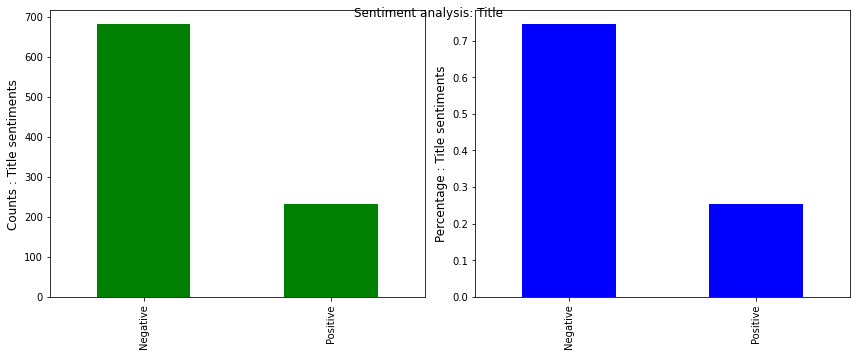

In [ ]:
df['title_sentiment'] = df['title'].apply(lambda x: find_sentiment(x))
plot_sentiment(df, 'title_sentiment', 'Title')

In [ ]:
df

,title,score,id,comms_num,title_sentiment
0,A Right Wing Group in Texas Is Making up Fake ...,166,ov1ll3,34,Negative
1,DOJ sues Texas over Gov. Abbott’s order for la...,85,ouwc9i,17,Negative
2,"From white evangelicals to QAnon believers, wh...",57,ouqkxi,27,Negative
3,DeSantis says he’ll sign order allowing parent...,269,oun2lc,138,Negative
4,"Show on the road: In Utah, Florida Gov. Ron De...",31,ouipnz,28,Negative
...,...,...,...,...,...
10448,Jake Ellzey wins Texas special election runoff...,39,ot1t5b,10,Positive
10449,Capitol Riot Officer Shares Voicemail Death Th...,1964,ot1qji,143,Negative
10450,The Justice Department Won’t Agree To Defend R...,255,ot1qep,7,Positive
10451,Judge Tells Biden Admin To Stop Releasing COVI...,0,ot1n04,11,Negative


In [ ]:
#encode y 

def zeroToOne(string):
    if(string =='Negative'):
        return int(0)
    else:
        return int(1)

df['title_sentiment'] = df['title_sentiment'].map(zeroToOne)

# the issue is in the encoder! to_xy won't recognize as classification if something other than int in target column
# title_sentiments = encode_text_index(df, 'title_sentiment')



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
df.title_sentiment.dtypes

dtype('int64')

In [ ]:
df.drop('id', axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
df

,title,score,comms_num,title_sentiment
0,A Right Wing Group in Texas Is Making up Fake ...,166,34,0
1,DOJ sues Texas over Gov. Abbott’s order for la...,85,17,0
2,"From white evangelicals to QAnon believers, wh...",57,27,0
3,DeSantis says he’ll sign order allowing parent...,269,138,0
4,"Show on the road: In Utah, Florida Gov. Ron De...",31,28,0
...,...,...,...,...
10448,Jake Ellzey wins Texas special election runoff...,39,10,1
10449,Capitol Riot Officer Shares Voicemail Death Th...,1964,143,0
10450,The Justice Department Won’t Agree To Defend R...,255,7,1
10451,Judge Tells Biden Admin To Stop Releasing COVI...,0,11,0


In [ ]:
# normalize numeric values 
numeric_cols = ['score', 'comms_num']
for col in range(len(df.columns)):
    if df.columns[col] in numeric_cols:
        encode_numeric_zscore(df, df.columns[col])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df

,title,score,comms_num,title_sentiment
0,A Right Wing Group in Texas Is Making up Fake ...,-0.243095,-0.245258,0
1,DOJ sues Texas over Gov. Abbott’s order for la...,-0.257310,-0.289296,0
2,"From white evangelicals to QAnon believers, wh...",-0.262224,-0.263391,0
3,DeSantis says he’ll sign order allowing parent...,-0.225019,0.024155,0
4,"Show on the road: In Utah, Florida Gov. Ron De...",-0.266787,-0.260801,0
...,...,...,...,...
10448,Jake Ellzey wins Texas special election runoff...,-0.265383,-0.307430,1
10449,Capitol Riot Officer Shares Voicemail Death Th...,0.072445,0.037108,0
10450,The Justice Department Won’t Agree To Defend R...,-0.227476,-0.315201,1
10451,Judge Tells Biden Admin To Stop Releasing COVI...,-0.272227,-0.304839,0


In [ ]:
# use one-hot encoding on timestamp beause it is a string
# encode_text_dummy(df, 'timestamp')  

In [ ]:
df

,title,score,comms_num,title_sentiment
0,A Right Wing Group in Texas Is Making up Fake ...,-0.243095,-0.245258,0
1,DOJ sues Texas over Gov. Abbott’s order for la...,-0.257310,-0.289296,0
2,"From white evangelicals to QAnon believers, wh...",-0.262224,-0.263391,0
3,DeSantis says he’ll sign order allowing parent...,-0.225019,0.024155,0
4,"Show on the road: In Utah, Florida Gov. Ron De...",-0.266787,-0.260801,0
...,...,...,...,...
10448,Jake Ellzey wins Texas special election runoff...,-0.265383,-0.307430,1
10449,Capitol Riot Officer Shares Voicemail Death Th...,0.072445,0.037108,0
10450,The Justice Department Won’t Agree To Defend R...,-0.227476,-0.315201,1
10451,Judge Tells Biden Admin To Stop Releasing COVI...,-0.272227,-0.304839,0


In [ ]:
# TF-IDF orders words by importance and uniqueness
# min_df: ignore terms that have a document frequency < min_df.
# max_df: ignore terms that have a document frequency > max_df
# max_features: build a vocabulary that only consists of the top max_features ordered by term frequency 
vectorizer = sk_text.TfidfVectorizer(stop_words='english', min_df=1)

matrix = vectorizer.fit_transform(df.title)
print(type(matrix))               # Compressed Sparse Row matrix

tfidf_data = matrix.toarray()     #  convert it to numpy array

print(tfidf_data)

<class 'scipy.sparse.csr.csr_matrix'>
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
print(vectorizer.get_feature_names())

['000', '06', '10', '100', '13', '17', '18', '19', '1960s', '1994', '1m', '1st', '1t', '200', '202', '2020', '2021', '2022', '2024', '2030', '21', '22', '220', '228', '230', '25', '26', '27', '289', '30', '31m', '32', '348', '40', '47', '49', '4b', '50', '500', '500k', '51', '550', '5t', '6103', '613', '62', '66', '6m', '6th', '70s', '73', '7m', '9mm', 'abandon', 'abbot', 'abbott', 'ability', 'abortion', 'abortions', 'abrams', 'absolutely', 'abuse', 'abused', 'abuses', 'academic', 'accelerates', 'accent', 'access', 'accessed', 'accidentally', 'accountability', 'accountable', 'accounts', 'accused', 'accuses', 'acknowledge', 'acknowledges', 'act', 'actblue', 'acting', 'action', 'actions', 'activists', 'acts', 'actually', 'adam', 'add', 'adding', 'address', 'adds', 'adequate', 'admin', 'administration', 'admit', 'admits', 'admitted', 'ads', 'adult', 'adults', 'advance', 'advances', 'advice', 'advisers', 'advises', 'advocacy', 'advocates', 'affair', 'affect', 'affordable', 'afghan', 'afgha

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
df = pd.concat([pd.DataFrame(tfidf_data), df], axis=1)

In [ ]:
df.drop('title', axis = 1, inplace = True)

In [ ]:
x, y = to_xy(df, 'title_sentiment')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

Target type: float64
Classifying correctly!


# CNN 


In [ ]:
#The SentimentIntensityAnalyzer should spit out "good" or "bad" 
#These two values will be hot encoded into 1 or 0.
#The Y column from Sentiment will be used to compare to
#A CNN and a Connected Neural Network 


In [ ]:
# convert x to data that will fit in a CNN properly
cnn_x = x.reshape((x.shape[0], 1, x.shape[1], 1))
cnn_x.shape

(1798, 1, 2777, 1)

In [ ]:
# split into train/test
x_train, x_test, y_train, y_test = train_test_split(cnn_x, y, test_size=0.25, random_state=42)

In [ ]:
cnn = Sequential()
# 64 filters of size 1 x 2. Each filter moves 2 pixels at a time 
cnn.add(Conv2D(64, kernel_size=(1, 2), strides=(2, 2),
                 activation='relu',
                 input_shape=x_train.shape[1:]))

# selects the max element from the region of the feature map covered by filter (filter size 1 x 2)
# the output will be a new feature map of the most prominent features of the previous feature map. helps prevent overfitting 
cnn.add(MaxPooling2D(pool_size=(1,2))) 

cnn.add(Conv2D(x_train.shape[2], kernel_size=(1, 2), strides=(1, 1),
                 activation='relu'))
cnn.add(MaxPooling2D(pool_size=(1,2)))
    
    
cnn.add(Flatten()) # convert input to 1D 
cnn.add(Dense(25, activation="relu")) # add fully connected layer
cnn.add(Dropout(0.5)) # prevent overfitting 
cnn.add(Dense(2, activation="softmax")) # output layer, 2 neurons because 2 possible classes 

# define optimizer and objective, compile cnn
cnn.compile(loss="categorical_crossentropy", optimizer="adam")

# train the cnn model
cnn.fit(x_train, y_train,     
          epochs=10,
          verbose=2,
          validation_data=(x_test, y_test))

Epoch 1/10
43/43 - 12s - loss: nan - val_loss: nan - 12s/epoch - 276ms/step
Epoch 2/10
43/43 - 2s - loss: nan - val_loss: nan - 2s/epoch - 40ms/step
Epoch 3/10
43/43 - 2s - loss: nan - val_loss: nan - 2s/epoch - 43ms/step
Epoch 4/10
43/43 - 2s - loss: nan - val_loss: nan - 2s/epoch - 43ms/step
Epoch 5/10
43/43 - 2s - loss: nan - val_loss: nan - 2s/epoch - 43ms/step
Epoch 6/10
43/43 - 2s - loss: nan - val_loss: nan - 2s/epoch - 40ms/step
Epoch 7/10
43/43 - 2s - loss: nan - val_loss: nan - 2s/epoch - 40ms/step
Epoch 8/10
43/43 - 2s - loss: nan - val_loss: nan - 2s/epoch - 41ms/step
Epoch 9/10
43/43 - 2s - loss: nan - val_loss: nan - 2s/epoch - 41ms/step
Epoch 10/10
43/43 - 2s - loss: nan - val_loss: nan - 2s/epoch - 40ms/step


In [ ]:
y_true = np.argmax(y_test, axis=1)
pred=cnn.predict(x_test)
pred = np.argmax(pred, axis=1)

In [ ]:
precision_score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(precision_score))

recall_score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(recall_score))

f1_score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(f1_score))

accuracy = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(accuracy))

print(metrics.classification_report(y_true, pred))

Precision score: 0.7665975308641976
Recall score: 0.8755555555555555
F1 score: 0.817461822011585
Accuracy: 0.8755555555555555
              precision    recall  f1-score   support

           0       0.88      1.00      0.93       394
           1       0.00      0.00      0.00        56

    accuracy                           0.88       450
   macro avg       0.44      0.50      0.47       450
weighted avg       0.77      0.88      0.82       450



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: 

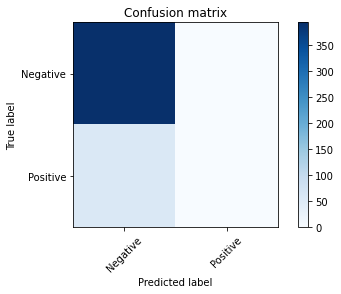

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
title_sentiments = ['Negative', 'Positive']

plt.figure()
plot_confusion_matrix(cm, title_sentiments)
plt.show()

# Fully Connected Neural Network

In [ ]:

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [ ]:
print(x.shape)
print(y.shape)

(1798, 2777)
(1798, 2)


In [ ]:
print(x.shape)

# this is our problem! y needs to be 2D 
# why is y not 2D? used same method for binary classification in project 3 
# maybe try different encode function for y? 
print(y.shape)

(1798, 2777)
(1798, 2)


In [ ]:
#The SentimentIntensityAnalyzer should spit out "good" or "bad" 
#These two values will be hot encoded into 1 or 0.
#The Y column from Sentiment will be used to compare to
#A CNN and a Connected Neural Network 

model = Sequential()
model.add(Dense(100, input_dim=x.shape[1], activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu')) 
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=2, verbose=2, mode='auto')

model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=2,epochs=1000)

Epoch 1/1000
43/43 - 1s - loss: nan - val_loss: nan - 783ms/epoch - 18ms/step
Epoch 2/1000
43/43 - 0s - loss: nan - val_loss: nan - 181ms/epoch - 4ms/step
Epoch 2: early stopping


In [ ]:
y_true = np.argmax(y_test, axis=1)
pred=model.predict(x_test)
pred = np.argmax(pred, axis=1)

# y_true = y_true.reshape(-1,1)

In [ ]:
precision_score = metrics.precision_score(y_true, pred, average= "weighted")
print("Precision score: {}".format(precision_score))

recall_score = metrics.recall_score(y_true, pred, average= "weighted")
print("Recall score: {}".format(recall_score))

f1_score = metrics.f1_score(y_true, pred, average= "weighted")
print("F1 score: {}".format(f1_score))

accuracy = metrics.accuracy_score(y_true, pred)
print('Accuracy: {}'.format(accuracy))

print(metrics.classification_report(y_true, pred))

Precision score: 0.7665975308641976
Recall score: 0.8755555555555555
F1 score: 0.817461822011585
Accuracy: 0.8755555555555555
              precision    recall  f1-score   support

           0       0.88      1.00      0.93       394
           1       0.00      0.00      0.00        56

    accuracy                           0.88       450
   macro avg       0.44      0.50      0.47       450
weighted avg       0.77      0.88      0.82       450



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: 

In [ ]:
# Print out feature names and their values 

df_y = pd.DataFrame(y_test, columns=['Actual Sentiment'])
df_pred = pd.DataFrame(pred, columns=['Predicted Sentiment'])
result = pd.concat([df_y, df_pred],axis=1)
result

ValueError: ignored

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true, pred)
title_sentiments = ['Negative', 'Positive']

plt.figure()
plot_confusion_matrix(cm, title_sentiments)
plt.show()